# Importing the data

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import folium

from geopy.distance import great_circle
from sklearn.cluster import DBSCAN as dbscan
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('../data/data_mmda_traffic_spatial_cleaned.csv')

In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

## Create GeoDateFrame from DataFrame

In [4]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))
gdf.crs = 'EPSG:4326'

## Import the spatial data for the boundary of the cities in Metro Manila

In [5]:
boundaries = gpd.read_file('../data/boundary_ncr/cleaned/boundary_ncr.shp')

# Perform the spatial join
accident_boundaries = gpd.sjoin(
    boundaries, gdf, predicate='contains', ).dropna()

# Select only the cities where accidents happened on our dataset
boundaries = boundaries[boundaries.index.isin(accident_boundaries.index)]
boundaries.reset_index(inplace=True, drop=True)

# Preparing the model
We will use the DBSCAN model to cluster vehicular accident hotspots in Metro Manila. This model is a density-based clustering model which means it will cluster points that are closer or packed together which is good for finding hotspots.

## Using geopy's great_circle method
To calculate the distance between points in DBSCAN, we will create a function that uses the latitude and longitude of two points and the great_circle function from geopy to determine the distance in meters, taking into account the curvature of the Earth.

In [6]:
def greatcircle(x, y):
    """
    Uses the latitude and longitude of two points and the great_circle function from geopy to determine the distance in meters, taking into account the curvature of the Earth.
    """
    lat1, long1 = x[0], x[1]
    lat2, long2 = y[0], y[1]
    dist = great_circle((lat1, long1), (lat2, long2)).meters
    return dist

## Finding the optimal eps
To find the optimal eps value for DBSCAN, we can use KNN and plot the distances between each point and its nearest neighbors and use the "knee" in the curve as a rough estimate of eps.

For more information (https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc)

In [7]:
coordinates = gdf[['Latitude', 'Longitude']].values

neigh = NearestNeighbors(n_neighbors=2, metric=greatcircle)
nbrs = neigh.fit(coordinates)

distances, indices = nbrs.kneighbors(coordinates)

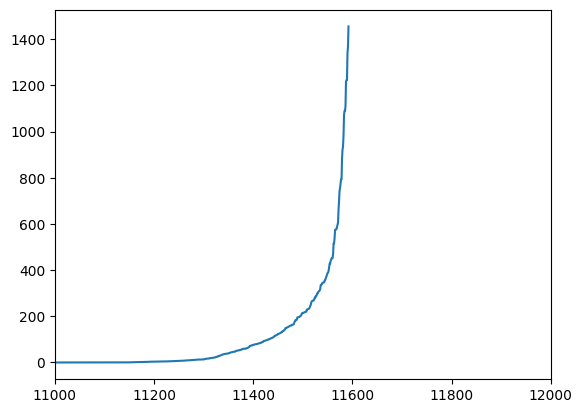

In [8]:
fig, ax = plt.subplots()

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.plot(distances)
ax.set_xlim(11000, 12000)
plt.show()

We can estimate a value of eps = *200* by looking at the knee (where the distance begin to increase more rapidly) of this plot.

# Training the model
Now we can train the model using the coordinates on our dataset to cluster vehicular accidents by their location.

In [9]:
# Setting hyperparameters
eps = 200
min_samples = 100

loc = gdf[['Latitude', 'Longitude']]

# Training the model
dbc = dbscan(eps=eps, min_samples=min_samples, metric=greatcircle).fit(loc)

In [10]:
labels = dbc.labels_
gdf['Cluster'] = labels

unique_labels = np.unique(labels)
unique_labels


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33])

In [11]:
# Subsetting the dataframe to accident hotspots only
accident_hotspots = gdf.drop(gdf[gdf['Cluster'] == -1].index)

# Visualization

## Creating a hotspot area for each clusters

In [12]:
# These are the metadata about each clusters
hotspot_centroids = accident_hotspots.groupby('Cluster').apply(lambda val: val.geometry.unary_union.centroid)
hotspot_count = accident_hotspots['Cluster'].value_counts()
hotspot_circles = accident_hotspots.groupby('Cluster').apply(lambda val: val.geometry.unary_union.centroid.buffer(len(val) / 100000))
hotspot_city = accident_hotspots.groupby('Cluster').apply(lambda val: boundaries[boundaries.contains(val.geometry.unary_union.centroid)]['NAME_2'].values[0])
hotspot_hour = accident_hotspots.groupby('Cluster').apply(lambda val: val['Datetime'].dt.hour.mode()[0])


/Users/amyrfrancisco/.pyenv/versions/3.9.9/envs/data/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [13]:
def military_to_12_hour(hour):
    """
    Converts military time hour in 12-hour format.
    """
    if hour == 0:
        return '12:00 AM'
    elif hour < 12:
        return f'{hour}:00 AM'
    elif hour == 12:
        return '12:00 PM'
    else:
        return f'{hour - 12}:00 PM'

In [14]:
hotspot_area = gpd.GeoDataFrame({'Circle': hotspot_circles, 'Centroid': hotspot_centroids, 'City': hotspot_city, 'Accident_Count': hotspot_count, 'Hour_Mode': hotspot_hour}, geometry='Circle')
hotspot_area['Hour_Mode'] = hotspot_area['Hour_Mode'].apply(lambda val: military_to_12_hour(val))
hotspot_area.head()

Circle  \
0  POLYGON ((121.04197 14.55978, 121.04196 14.559...   
1  POLYGON ((121.06082 14.59243, 121.06081 14.592...   
2  POLYGON ((121.05144 14.57263, 121.05142 14.572...   
3  POLYGON ((121.04928 14.62809, 121.04927 14.627...   
4  POLYGON ((121.05405 14.61691, 121.05404 14.616...   

                                        Centroid         City  Accident_Count  \
0                  POINT (121.040718 14.5597825)  Makati City             125   
1  POINT (121.05871216666667 14.592427916666665)  Quezon City             211   
2  POINT (121.04756790000003 14.572627549999996)  Mandaluyong             387   
3  POINT (121.04714604872106 14.628093385759275)  Quezon City             213   
4       POINT (121.052310375 14.616909999999999)  Quezon City             174   

  Hour_Mode  
0   3:00 PM  
1   9:00 AM  
2   2:00 PM  
3   5:00 AM  
4   9:00 AM

In [15]:
hotspot_area = hotspot_area.sort_values('Accident_Count', ascending=False).reset_index(drop=True)


## Visualizing the hotspots with their corresponding information

In [16]:
colors = [
    '#FF0000',  # Red
    '#00FF00',  # Green
    '#0000FF',  # Blue
    '#FFFF00',  # Yellow
    '#00FFFF',  # Cyan
    '#FF00FF',  # Magenta
    '#C0C0C0',  # Silver
    '#808080',  # Gray
    '#000000',  # Black
    '#800000',  # Maroon
    '#008000',  # Olive
    '#000080',  # Navy
    '#808000',  # Purple
    '#800080',  # Teal
    '#008080',  # Lime
    '#FFC0CB',  # Pink
    '#FFA500',  # Orange
    '#FFFFE0',  # Light Yellow
    '#ADD8E6',  # Light Blue
    '#F08080',  # Light Coral
    '#E0FFFF',  # Light Cyan
    '#FAFAD2',  # Light Goldenrod
    '#D3D3D3',  # Light Gray
    '#90EE90',  # Light Green
    '#D3D3D3',  # Light Grey
    '#FFB6C1',  # Light Pink
    '#FFFFF0',  # Light Thistle
    '#87CEFA',  # Light Sky Blue
    '#778899',  # Light Slate Gray
    '#B0C4DE',  # Light Steel Blue
    '#FFFFFF',  # White
    '#FF69B4',  # Hot Pink
    '#00CED1',  # Dark Turquoise
    '#9400D3',  # Dark Violet
]

In [17]:
location = gdf['Latitude'].mean(), gdf['Longitude'].mean()

map = folium.Map(location=location, zoom_start=12)

folium.TileLayer('cartodbpositron').add_to(map)

for _, row in accident_hotspots.iterrows():
    col = colors[row['Cluster']]
    folium.CircleMarker([row['Latitude'], row['Longitude']], radius=10, color=col, fill=col).add_to(map)

for i in range(len(hotspot_area)):
    style = {'fillColor': '#FF0000', 'color': '#FF0000'}
    geojson = folium.GeoJson(hotspot_area.loc[i, 'Circle'], style_function=(lambda x: style))
    popup = folium.Popup('<strong>No. of Accidents: </strong>{}<br><br><strong>Hour_Mode: </strong>{}<br><br><strong>City: </strong>{}<br><br><strong>Center coordinates: </strong>{}, {}'.format(
        hotspot_area.loc[i, 'Accident_Count'], hotspot_area.loc[i, 'Hour_Mode'], hotspot_area.loc[i, 'City'], hotspot_area.loc[i, 'Centroid'].y, hotspot_area.loc[i, 'Centroid'].x))
    popup.add_to(geojson)
    geojson.add_to(map)

map

*This map shows the vehicular accident hotspots in Metro Manila with varying sizes corresponding to how many accidents occur on the hotspot.*

This map is interactive, you can ***zoom in and out*** and ***click on each hotspot*** to find information about:
- No. of Accidents on the hotspot
- Frequent time of the day when accidents occur on the hotspot
- The city where the center of the hotspot belong
- The coordinates of the center of the hotspot